# Working with Data APIs

**Sam Maurer // DCRP PhD Student // maurer@berkeley.edu // Oct. 7, 2015 // CP 255 demo**

This notebook is the demo portion of an introduction to APIs, with particular emphasis on data-access APIs that operate over the web.

In Part 1, we'll read and parse data from an automated USGS feed of earthquakes. In Part 2, we'll add query parameters to the workflow, using the Google Maps Geolocation API as an example. In Part 3, we'll add authentication and data streaming in order to access some Twitter APIs. 

### Setup (not required until Part 3)

1. **From the command line, install this Python package for connecting to Twitter APIs:**  
   `pip install TwitterAPI`  
     
   There are several different package managers for Python. We're using "pip install" instead of "conda install" because Anaconda doesn't include this package in its index. The lab computers should already have TwitterAPI installed.  
   &nbsp;

2. **Make sure `keys.py` is in the same directory as this notebook**  
     
   `keys.py` (provided separately) contains demo authentication keys for the Twitter APIs. For folks not taking the class, you can edit the `keys-example.py` file, following the instructions in the next step to obtain your own credentials.  
   &nbsp;
   
3. **OPTIONAL: Sign up for your own Twitter API credentials (5 minutes)**  
     
   Twitter limits the number of simultaneous connections from a single account, so if you're willing to sign up for your own credentials, it will help the in-class demo go smoother!  
     
   * Log into Twitter or create an account: http://twitter.com  
     &nbsp;
     
   * Register a new app development project: https://dev.twitter.com/apps/new  
     &nbsp;  
     (The form is geared toward people making smartphone or web apps, but you still have to fill it out... You can call the app an in-class demo and give the URL of your own Twitter page, for example)  
     &nbsp;
     
   * Submit the form, go to the "Keys and Access Tokens" tab, and click on "Create my access token" at the bottom of the page  
     &nbsp;
     
   * Copy these four codes into the `keys.py` file, replacing the demo credentials:  
     (a) consumer key, (b) consumer secret, (c) access token, (d) access token secret  
     &nbsp;
     
   * All done! Try running the first few code blocks in Part 3 to see if it worked
   
----- 

-----

# Part 1: Reading from an automated data feed

### USGS real-time earthquake feeds

This is an API for near-real-time data on earthquakes. Results are provided in JSON format via HTTP. No authentication is needed, and rather than accepting arguments, the API has a separate endpoint for each permutation of the data.

**API documentation:**  
http://earthquake.usgs.gov/earthquakes/feed/v1.0/geojson.php

**Sample API endpoint, for magnitude 4.5+ earthquakes in past day:**  
http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/4.5_day.geojson  


In [12]:
%matplotlib inline

import pandas as pd
import urllib
import json

In [31]:
# use endpoint for magnitude 2.5+ in past week
endpoint_url = "http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_week.geojson"

# open a connection to the URL
connection = urllib.urlopen(endpoint_url)

# download the results
results = connection.read()

print results[:500]  # first 500 characters
print type(results)

{"type":"FeatureCollection","metadata":{"generated":1444111203000,"url":"http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_week.geojson","title":"USGS Magnitude 2.5+ Earthquakes, Past Week","status":200,"api":"1.0.17","count":271},"features":[{"type":"Feature","properties":{"mag":4.7,"place":"89km WSW of Coquimbo, Chile","time":1444107104460,"updated":1444108238620,"tz":-300,"url":"http://earthquake.usgs.gov/earthquakes/eventpage/us10003kme","detail":"http://earthquake.usgs.gov/earthq
<type 'str'>


In [32]:
# the results are a string with JSON-formatted data inside

# parse the string into a Python data structure
data = json.loads(results)

print data['features'][0]  # first item from the array called 'features'
print type(data)

{u'geometry': {u'type': u'Point', u'coordinates': [-72.1952, -30.2732, 9.52]}, u'type': u'Feature', u'properties': {u'rms': 1.46, u'code': u'10003kme', u'cdi': 1, u'sources': u',us,', u'nst': None, u'tz': -300, u'title': u'M 4.7 - 89km WSW of Coquimbo, Chile', u'magType': u'mwr', u'detail': u'http://earthquake.usgs.gov/earthquakes/feed/v1.0/detail/us10003kme.geojson', u'sig': 340, u'net': u'us', u'type': u'earthquake', u'status': u'reviewed', u'updated': 1444108238620, u'felt': 0, u'alert': None, u'dmin': 0.627, u'mag': 4.7, u'gap': 89, u'types': u',cap,dyfi,geoserve,moment-tensor,nearby-cities,origin,phase-data,tectonic-summary,', u'url': u'http://earthquake.usgs.gov/earthquakes/eventpage/us10003kme', u'ids': u',us10003kme,', u'tsunami': 0, u'place': u'89km WSW of Coquimbo, Chile', u'time': 1444107104460, u'mmi': None}, u'id': u'us10003kme'}
<type 'dict'>


In [33]:
# pull out the event descriptions

for quake in data['features']:
    print quake['properties']['title']

M 4.7 - 89km WSW of Coquimbo, Chile
M 3.0 - 8km WNW of Anza, California
M 2.7 - 9km NNW of Shelbyville, Kentucky
M 4.6 - 84km W of Illapel, Chile
M 4.2 - 70km NW of Rapar, India
M 3.9 - 135km NE of Chignik Lake, Alaska
M 2.7 - 54km ESE of Lovelock, Nevada
M 4.1 - 69km WNW of La Ligua, Chile
M 4.2 - 71km WNW of La Ligua, Chile
M 2.5 - 68km ESE of Lakeview, Oregon
M 2.7 - 68km ESE of Lakeview, Oregon
M 2.6 - 8km SE of Pole Ojea, Puerto Rico
M 2.6 - 23km N of Upper Lake, California
M 2.8 - 23km W of Perry, Oklahoma
M 5.7 - 74km N of Amatignak Island, Alaska
M 4.7 - 158km WSW of Ovalle, Chile
M 5.9 - 43km SSW of Coquimbo, Chile
M 2.9 - 69km ESE of Lakeview, Oregon
M 2.6 - 42km SSW of Larsen Bay, Alaska
M 3.0 - 95km WSW of Healy, Alaska
M 3.4 - 85km N of Road Town, British Virgin Islands
M 2.5 - 54km E of Old Iliamna, Alaska
M 3.0 - 94km WSW of Healy, Alaska
M 2.9 - 83km W of Cantwell, Alaska
M 4.5 - 32km N of Ramechhap, Nepal
M 3.5 - 20km E of Cherokee, Oklahoma
M 2.9 - 81km NNW of Talkeet

In [34]:
# pull out magnitudes and depths into a pandas dataframe

# first, set up a dictionary of empty arrays
d = {'magnitude': [], 'depth': []}

# loop through the earthquakes and pull out datapoints
for quake in data['features']:
    d['magnitude'].append(quake['properties']['mag'])
    d['depth'].append(quake['geometry']['coordinates'][2])

# then load it all into a dataframe
df = pd.DataFrame.from_dict(d)

print len(df)

271


In [35]:
print df.head()

   depth  magnitude
0   9.52       4.70
1  11.18       2.97
2   4.09       2.65
3  26.07       4.60
4  10.00       4.20


In [36]:
print df.describe()

            depth   magnitude
count  271.000000  271.000000
mean    47.599384    3.706753
std     86.633670    0.977558
min      0.000000    2.500000
25%     10.000000    2.800000
50%     19.300000    3.400000
75%     47.480000    4.600000
max    559.030000    5.900000


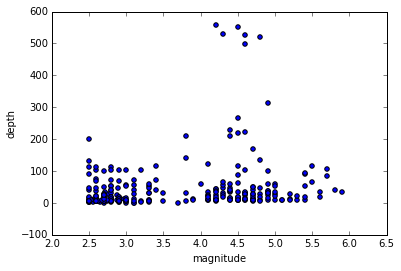

In [37]:
# plot the depth vs. magnitude

df.plot(x='magnitude', y='depth', kind='scatter')

In [38]:
# save dataframe to disk

df.to_csv('usgs_earthquake_data.csv')

print 'file saved'

file saved


In [40]:
# read it back later

new_df = pd.DataFrame.from_csv('usgs_earthquake_data.csv')

print new_df.head()

   depth  magnitude
0   9.52       4.70
1  11.18       2.97
2   4.09       2.65
3  26.07       4.60
4  10.00       4.20


# Part 2: Querying an API endpoint

### Google Maps Geocoding API

Google Maps has several APIs for getting search results as data. This one looks up latitude-longidtude coordinates (and other place information) for street addresses, which is called geocoding. 

It works similarly to the earthquakes example, with query parameters added to the URL endpoint.

**API documentation:**  
https://developers.google.com/maps/documentation/geocoding/intro

**API endpoint:**  
https://maps.googleapis.com/maps/api/geocode/json

**API endpoint with query parameters:**  
https://maps.googleapis.com/maps/api/geocode/json?address=Wurster+Hall

In [15]:
# we have to encode the search query so that it can be passed as a URL, 
# with spaces and other special characters removed

endpoint = 'https://maps.googleapis.com/maps/api/geocode/json'

params = {
    'address': 'Wurster Hall, Berkeley, CA',
}

url = endpoint + '?' + urllib.urlencode(params)
print url

https://maps.googleapis.com/maps/api/geocode/json?address=Wurster+Hall%2C+Berkeley%2C+CA


In [16]:
# open a connection to the URL
connection = urllib.urlopen(url)

# download and parse the results
results = json.loads(connection.read())

print results

{u'status': u'OK', u'results': [{u'geometry': {u'location_type': u'ROOFTOP', u'bounds': {u'northeast': {u'lat': 37.871116, u'lng': -122.2541912}, u'southwest': {u'lat': 37.8700084, u'lng': -122.2552699}}, u'viewport': {u'northeast': {u'lat': 37.8719111802915, u'lng': -122.2533815697085}, u'southwest': {u'lat': 37.86921321970851, u'lng': -122.2560795302915}}, u'location': {u'lat': 37.8707352, u'lng': -122.2548935}}, u'address_components': [{u'long_name': u'Wurster Hall', u'types': [u'premise'], u'short_name': u'Wurster Hall'}, {u'long_name': u'Berkeley', u'types': [u'locality', u'political'], u'short_name': u'Berkeley'}, {u'long_name': u'Alameda County', u'types': [u'administrative_area_level_2', u'political'], u'short_name': u'Alameda County'}, {u'long_name': u'California', u'types': [u'administrative_area_level_1', u'political'], u'short_name': u'CA'}, {u'long_name': u'United States', u'types': [u'country', u'political'], u'short_name': u'US'}, {u'long_name': u'94720', u'types': [u'po

In [96]:
# pull out the formatted addresses

for item in results['results']:
    print item['formatted_address']

Wurster Hall, Berkeley, CA 94720, USA


# Part 3: Querying an API with authentication

### Twitter REST and Streaming APIs

Twitter's APIs also operate over HTTP, but they require a back-and-forth authentication process at the beginning of a connection. It's easier to have a Python library handle this than to create the query URLs ourselves.

The REST APIs perform stand-alone operations: we submit a query and receive results, like in earlier examples. The Streaming API continues sending results in real time until we disconnect.

**API documentation:**  
https://dev.twitter.com/rest/public  
https://dev.twitter.com/streaming/overview

**Documentation for third-party Python "wrapper"**:  
https://github.com/geduldig/TwitterAPI

In [1]:
from TwitterAPI import TwitterAPI

In [2]:
# import API credentials from keys.py file in the
# same directory as this notebook

from keys import *

In [3]:
# set up an API connection using credentials from the keys file

api = TwitterAPI(consumer_key, consumer_secret, 
                 access_token, access_token_secret)

print "Connection is set up but not tested"

Connection is set up but not tested


### Making a simple data request

In [4]:
# Most recent tweet from @GBoeing's timeline

endpoint = 'statuses/user_timeline'
params = {
    'screen_name': 'gboeing', 
    'count': 1
}
r = api.request(endpoint, params)

for tweet in r.get_iterator():
    print tweet['text']

@coleman Yep! There's a link here http://t.co/UMsr37isHL to our GitHub repo where we're sharing materials as the semester goes along.


In [5]:
# What other data is there?

print tweet.keys()

[u'contributors', u'truncated', u'text', u'is_quote_status', u'in_reply_to_status_id', u'id', u'favorite_count', u'source', u'retweeted', u'coordinates', u'entities', u'in_reply_to_screen_name', u'id_str', u'retweet_count', u'in_reply_to_user_id', u'favorited', u'user', u'geo', u'in_reply_to_user_id_str', u'possibly_sensitive', u'lang', u'created_at', u'in_reply_to_status_id_str', u'place']


In [6]:
# Contents of some additional fields...
# Here are the definitions: https://dev.twitter.com/overview/api/tweets

for tweet in r.get_iterator():
    print "Tweet      // ", tweet['text']
    print "Timestamp  // ", tweet['created_at']
    print "Retweets   // ", tweet['retweet_count']
    print "Favorites  // ", tweet['favorite_count']
    print "Geotag     // ", tweet['coordinates']
    print "Language   // ", tweet['lang']
    print "User       // ", tweet['user']['screen_name']
    print "Followers  // ", tweet['user']['followers_count']
    print "Profile    // ", tweet['user']['description']

Tweet      //  @coleman Yep! There's a link here http://t.co/UMsr37isHL to our GitHub repo where we're sharing materials as the semester goes along.
Timestamp  //  Mon Oct 05 23:30:52 +0000 2015
Retweets   //  0
Favorites  //  0
Geotag     //  None
Language   //  en
User       //  gboeing
Followers  //  1671
Profile    //  PhD candidate in urban planning at @UCBerkeley. Cities, complexity, livability, urban design, data.


### Other API endpoints allow different types of searches

In [9]:
# Search for public tweets about #muni

endpoint = 'search/tweets'
params = {
    'q': '#muni', 
    'count': 5
}
r = api.request(endpoint, params)

for tweet in r.get_iterator():
    print tweet['text'] + '\n'

Just for reference: The #FolsomStreetFair was 8 days ago. #SF #perpetualFolsom #leather #MUNI… https://t.co/28WOhB6tyt

Nose chau a dormirrr #muni #oficina

RT @sfbay: Earlier: Geary bus rapid transit project hits milestone http://t.co/mxESEwndx4 #Muni via @JChinn84 http://t.co/Ss1BC2w8VU

Not a BRT, you do wonder if these "advisors" have ever tried to ride the #muni F in #SF because that's the disruptive LOS they're planning.

RT @sfbay: Earlier: Geary bus rapid transit project hits milestone http://t.co/mxESEwndx4 #Muni via @JChinn84 http://t.co/Ss1BC2w8VU



In [10]:
# Search for public tweets in Hindi

endpoint = 'search/tweets'
params = {
    'q': '*', 
    'lang': 'hi', 
    'count': 5
} 
r = api.request(endpoint, params)

for tweet in r.get_iterator():
    print tweet['text'] + '\n'

लालू ने मीडिया को गाली दी http://t.co/s2bwQCbIla

@rksir1 @saurabhshukla0 hum ahinsake pujari sirf isliyehai taaki gandagi gandagiko khud us hadhtak saaf kare jab sirf do hath safai ke kabil

मीडिया विश्लेषक Utpal Kalal-'सच में संत और राष्ट्रहित में लगे लोगों पर झूठे आरोप लगाकर #Media420 आस्था से खिलवाड़ कर रहा है'

RT @chiya9: "मैं सुषमा स्वराज ( foreign minister)
"आप विदेश नहीं जाती ???
" मेरी duty बस airport तक ही है http://t.co/VAEx7HqIMz

पायल हज़ारो रूपये में आती है पर
पैरो में पहनी जाती है..
और
बिंदी 2 रूपये में आती है मगर माथे पर
सजाई जाती है..... http://t.co/GqJ6BdrO41



In [50]:
# Search for public tweets geotagged near the UC Berkeley campus

endpoint = 'search/tweets'
params = {
    'q': '*', 
    'geocode': '37.873,-122.260,0.5km', 
    'count': 5
} 
r = api.request(endpoint, params)

for tweet in r.get_iterator():
    print tweet['text'] + '\n'

Soka University had a blast at UC Berkeley's graduate school fair. Our Admission Operations… https://t.co/x7RvEOCGlB

Hot Seller: Mummenschanz @ Cal Performances' Zellerbach Hall (Berkeley, CA) http://t.co/GenMFwHU4r http://t.co/owzw7rGpvD

Hot Seller: Mummenschanz @ Cal Performances' Zellerbach Hall (Berkeley, CA) http://t.co/gsUuiC5Iop http://t.co/hzDQufCQIl

Hot Seller: Mummenschanz @ Cal Performances' Zellerbach Hall (Berkeley, CA) http://t.co/KY6vpLcpzc http://t.co/XYRqSHPQPh

t h r o w b a c k  2 last fall 🍂 @ UC Berkeley https://t.co/aStbSLJPsl



### Exercise

1. Try some different search queries!
2. Display some more data fields in addition to the tweet text
3. Advanced: can you figure out how to use the API to *post* a tweet?

Here's the search documentation: https://dev.twitter.com/rest/reference/get/search/tweets




### Streaming live tweets in real time 

In [53]:
# Twitter limits simultaneous connections to the streaming API,
# so this part may not work using the demo API keys during class

endpoint = 'statuses/filter'
params = {'locations': '-180,-90,180,90'}
r = api.request(endpoint, params)

# 'enumerate' lets us count tweets as we receive them

for i, tweet in enumerate(r.get_iterator()):
    print tweet['created_at']
    print tweet['place']['full_name'] + ', ' + tweet['place']['country']
    print tweet['text'] + '\n'
    if (i > 20): break

r.close()  # close streaming connection

Tue Oct 06 06:26:36 +0000 2015
Scotland, United Kingdom, United Kingdom
@hannykha Welcome back Hannah.

Tue Oct 06 06:26:37 +0000 2015
Khlong Tan Nuea, Bangkok, ประเทศไทย
ไม่อยากต่อความยาวสาวความยืดนะ แต่ถ้านี่เป็นพี่ขวัญจะบีบให้เขาขอโทษ 555555 ดูบิชนะแต่มันคือมารยาทที่สังคมพึงมี ให้จำไว้เป็นบทเรียนด้วย

Tue Oct 06 06:26:37 +0000 2015
Bengaluru, Karnataka, India
@musicnews_shade  WHAT'S WANTED ?? LOL

Tue Oct 06 06:26:37 +0000 2015
South Carolina, USA, United States
SOMEBODY TRYNA CALL ME RIGHT QUICK WHILE I WALK HOME?

Tue Oct 06 06:26:37 +0000 2015
Limoges, Limousin, France
Casseurs Flowteurs avec une grosse pensée à @FunalotPierre et @OrellDelonge 😘

Tue Oct 06 06:26:37 +0000 2015
New Orleans, LA, United States
😩 tripping  https://t.co/2YsYvu6te1

Tue Oct 06 06:26:37 +0000 2015
Rio de Janeiro, Brasil, Brasil
eu não to bem

Tue Oct 06 06:26:37 +0000 2015
San Antonio, TX, United States
Ok I need to shower now. Leave me cute things to get back to. K? K. 😛

Tue Oct 06 06:26:36 +0000 201

### Loading tweets into a dataframe

In [73]:
# first, save some tweets to an array instead of just printing them

r = api.request(endpoint, params)
tweets = []

for i, tweet in enumerate(r.get_iterator()):
    if (i >= 500): break
    tweets.append(tweet)

r.close()
print len(tweets)

5000


In [55]:
# the raw data is very messy though!

print tweets[0:5]

[{u'contributors': None, u'truncated': False, u'text': u"I've learned not to sweat the small stuff, if it's something worth stressing over then you have the power to change it.", u'is_quote_status': False, u'in_reply_to_status_id': None, u'id': 651282410739363840, u'favorite_count': 0, u'source': u'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', u'retweeted': False, u'coordinates': None, u'timestamp_ms': u'1444112801619', u'entities': {u'user_mentions': [], u'symbols': [], u'hashtags': [], u'urls': []}, u'in_reply_to_screen_name': None, u'id_str': u'651282410739363840', u'retweet_count': 0, u'in_reply_to_user_id': None, u'favorited': False, u'user': {u'follow_request_sent': None, u'profile_use_background_image': False, u'default_profile_image': False, u'id': 2450801982, u'verified': False, u'profile_image_url_https': u'https://pbs.twimg.com/profile_images/645710965237874688/EGgGBKVh_normal.jpg', u'profile_sidebar_fill_color': u'000000', u'profile_te

In [74]:
# we'll pull out some pieces into a dataframe

# first, set up a dictionary of empty arrays
d = {'place': [], 'latitude': [], 'longitude': []}

for t in tweets:
    try:
        # first check whether the fields we want exist
        _test = t['coordinates']['coordinates']
        
        # then pull out the data
        d['place'].append(t['place']['name'])
        d['latitude'].append(t['coordinates']['coordinates'][1])
        d['longitude'].append(t['coordinates']['coordinates'][0])
        
    except:
        # if the test failed, continue to next tweet
        continue

# load it into a dataframe
df = pd.DataFrame.from_dict(d)

print len(df)

998


In [70]:
print df.head()

    latitude   longitude                place
0  -7.332000  110.509540              Tingkir
1  35.185259 -111.655590            Flagstaff
2  34.492600 -117.351930  Mountain View Acres
3  50.818800    3.338635             Zwevegem
4  40.976127   29.096884             İstanbul


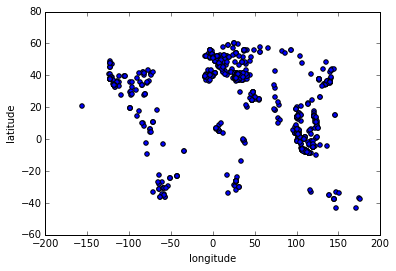

In [77]:
df.plot(x='longitude', y='latitude', kind='scatter')

In [76]:
# Note that when working with text strings that include characters from 
# other alphabets, you sometimes need to specify the text encoding.

# Some interesting related reading:
# - http://www.joelonsoftware.com/articles/Unicode.html

df.to_csv('saved_coords.csv', encoding='utf-8')

### Exercise

Choose one:

1. Using one of the APIs from this demo, save and graph a different aspect of the data.  
   &nbsp;

2. Or, search the web for another API that provides data you're interested in. Can you figure out how to connect to it?

Some common terms for describing these APIs that operate over the web are "HTTP" and "REST". The most frequent data format is JSON, but with some code modifications you can parse other formats as well.